<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Обучение моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
ddd
 
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.metrics import mean_squared_error, make_scorer

In [2]:
# импорт данных
data = pd.read_csv('/datasets/taxi.csv', 
                   index_col=[0], parse_dates=[0])

In [3]:
# сортировка по индексу
data.sort_index(inplace=True) 

In [4]:
# ресемплирование данных по 1 часу
data = data.resample('1H').sum()

In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
data.shape

(4416, 1)

## Анализ

In [7]:
# добавим скользящее среднее
data['rolling_mean'] = data.rolling(24).mean()

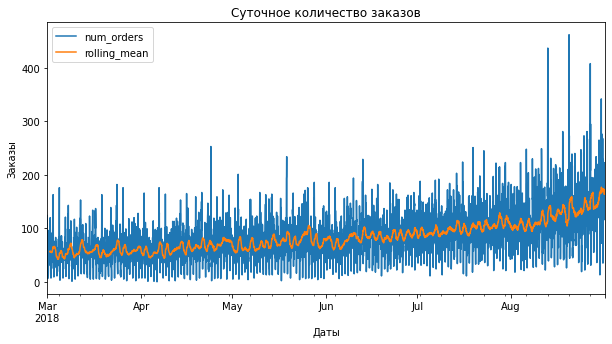

In [8]:
# отобразим на графике 
ax = data.plot(figsize=(10,5), title = 'Суточное количество заказов')
ax.set_xlabel('Даты')
ax.set_ylabel('Заказы')

plt.show()

По графику скользящего среднего заметно проявление сезонности, а именно перепады количества заказов в зависимости от времени суток. 

Также заметен тренд на увеличение количества заказов.

In [9]:
# Разложим временной ряд на тренд и сезонную компоненту.
decomposed = seasonal_decompose(data['num_orders'])

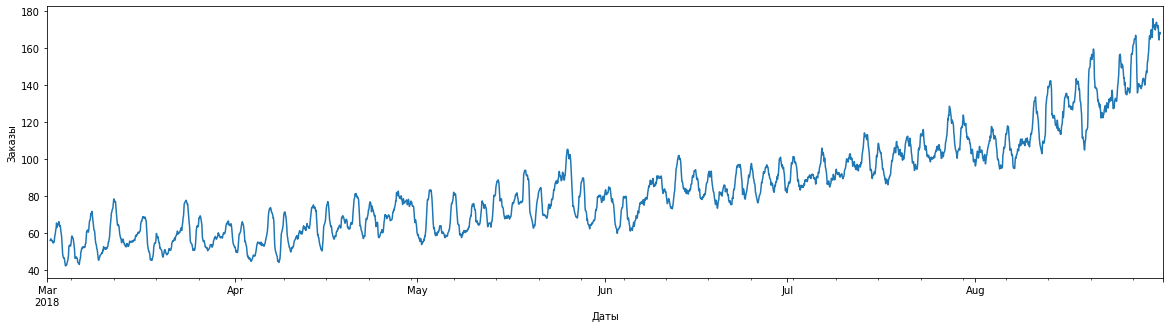

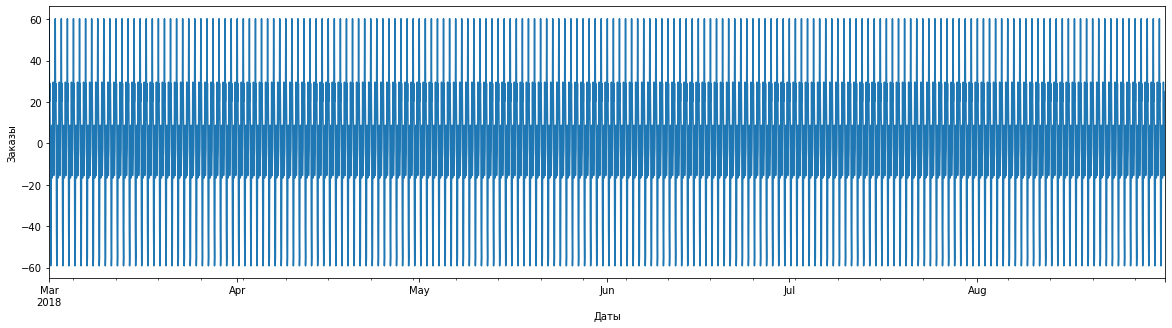

In [ ]:
# отобразим на графиках

# тренд
ax = decomposed.trend.plot(figsize=(20,5))
ax.set_xlabel('Даты')
ax.set_ylabel('Заказы')
plt.show()

# сезонность
ax = decomposed.seasonal.plot(figsize=(20,5))
ax.set_xlabel('Даты')
ax.set_ylabel('Заказы')
plt.show()

# остаток декомпозиции
ax = decomposed.resid.plot(figsize=(20,5))
ax.set_xlabel('Даты')
ax.set_ylabel('Заказы')
plt.show()

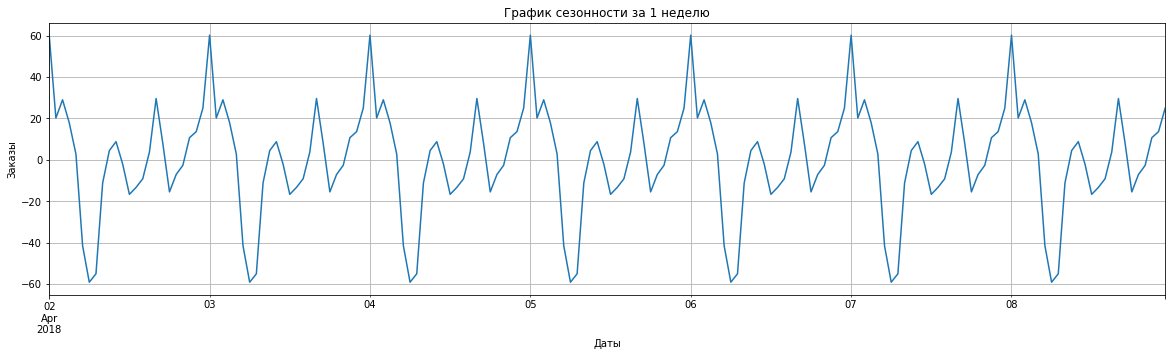

In [11]:
# рассмотри сезонность подробнее, на примере 1 полной недели
ax = decomposed.seasonal['2018-04-02':'2018-04-08'].plot(
    figsize=(20,5), 
    title = 'График сезонности за 1 неделю')
ax.set_xlabel('Даты')
ax.set_ylabel('Заказы')
ax.grid(axis='both', which='both')

plt.show()

На графике сезонности заметна четкая суточная сезонность. Недельная сезонность никак себя не проявляет.

В рамках суток наиболее загруженное время - в районе полуночи, наименее загруженное - утренние часы. Поскольку графики заказов привязаны к заказам из аэропортов, можно связать такие суточные перепады с определенным графиком прибытия рейсов. 

**Промежуточный вывод**

- выборка была разделена на составляющие seasonal_decompose()
- на всем периоде наблюдений явно видна сезонность в рамках суток
- наиболее загруженные часы - ночные, наименее загруженные - утренние
- вероятно такое распределение связано с графиком прибытия рейсов
- имеет место четкий тренд на возрастание кол-ва заказов/час
- тренд также может быть связан с характером данных (аэоропорты) - в летние месяцы туристический поток возрастает, что и увеличивает нагрузку на такси. Чтобы оценить корректость этого предположения, нужно иметь данные как минимум за полный год.


## Обучение

**Подготовка функций**

In [12]:
# функция вычисления метрики RMSE

def rmse(real, predictions):
    return mean_squared_error(real, predictions) ** 0.5

In [13]:
# функция генерации дополнительных признаков для обучения модели 

def make_features(data, max_lag, rolling_mean_size):
    # дополнительные признаки даты/времени
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    # данные из прошлого с лагом на требуемое кол-во часов
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # перезапишем скользящее среднее. 
    # делаем смещение shift() чтобы избежать попадания цели в признаки
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [14]:
# функция отображения результатов обучения моделей
def show_metrics(model, real, features_to_predict):
    print('-'*50)
    print(type(model))
    print('RMSE: ', rmse(real, model.predict(features_to_predict)))
    print('-'*50)

---
**Подготовка обучающей и тестовой выборок**

In [15]:
# создадим признаки
make_features(data, 4, 4)

# удалим пропуски
data = data.dropna()

data.head()

,num_orders,rolling_mean,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4
datetime,,,,,,,,,,
2018-03-01 04:00:00,43,86.50,3,1,4,3,66.0,71.0,85.0,124.0
2018-03-01 05:00:00,6,66.25,3,1,5,3,43.0,66.0,71.0,85.0
2018-03-01 06:00:00,12,46.50,3,1,6,3,6.0,43.0,66.0,71.0
2018-03-01 07:00:00,15,31.75,3,1,7,3,12.0,6.0,43.0,66.0
2018-03-01 08:00:00,34,19.00,3,1,8,3,15.0,12.0,6.0,43.0


In [16]:
# разделим целевые значения и признаки
target = data['num_orders']
features = data.drop('num_orders', axis=1)

In [17]:
# подготовим обучающую и тестовую выборки
# в пропорции 90%/10%

features_train, features_test, target_train, target_test = (
    train_test_split(features, target, shuffle=False, test_size=0.1))
print('features_train.shape', features_train.shape)
print('features_test.shape', features_test.shape)

features_train.shape (3970, 9)
features_test.shape (442, 9)


---
**Нормализация данных**

In [18]:
# скалируем признаки
scaler = StandardScaler()

features_train_scaled = pd.DataFrame(
    scaler.fit_transform(features_train))

features_test_scaled = pd.DataFrame(
    scaler.transform(features_test))

display(features_train_scaled.head())
display(features_test_scaled.head())

,0,1,2,3,4,5,6,7,8
0,0.277957,-1.413472,-1.593142,-1.083255,-0.012832,-0.317243,-0.187822,0.174631,1.184041
1,-0.404765,-1.413472,-1.593142,-0.938675,-0.012832,-0.911959,-0.317110,-0.187505,0.174897
2,-1.070630,-1.413472,-1.593142,-0.794096,-0.012832,-1.868677,-0.911833,-0.316840,-0.187359
3,-1.567922,-1.413472,-1.593142,-0.649516,-0.012832,-1.713534,-1.868562,-0.911777,-0.316737
4,-1.997785,-1.413472,-1.593142,-0.504936,-0.012832,-1.635962,-1.713416,-1.868850,-0.911872


,0,1,2,3,4,5,6,7,8
0,1.668688,1.755426,-0.240539,0.362542,-1.511164,1.053191,0.355186,1.700775,2.012055
1,1.213540,1.755426,-0.240539,0.507121,-1.511164,0.613618,1.053339,0.355698,1.701550
2,1.474829,1.755426,-0.240539,0.651701,-1.511164,2.501196,0.613761,1.054103,0.356026
3,1.913120,1.755426,-0.240539,0.796281,-1.511164,1.699621,2.501361,0.614367,1.054663
4,2.191266,1.755426,-0.240539,0.940861,-1.511164,1.906479,1.699778,2.502647,0.614780


### Обучение моделей

In [19]:
# список для сохранения моделей
models = []

---
**Обучение модели LinearRegression**

In [20]:
model_linreg = LinearRegression()
%timeit -r 1 model_linreg.fit(features_train_scaled, target_train)

models.append(model_linreg)

5.09 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


---
**Обучение модели Ridge**

In [21]:
model_ridge = Ridge()
%timeit -r 1 model_ridge.fit(features_train_scaled, target_train)

models.append(model_ridge)

5.98 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


---
**Обучение модели LogisticRegression**

In [22]:
model_logreg = LogisticRegression(max_iter = 500, solver='liblinear')
%timeit -r 1 model_logreg.fit(features_train_scaled, target_train)

models.append(model_logreg)

992 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


---
**Обучение модели RandomForest**

In [23]:
%%time

# используем кросс-валидацию для временных рядов
# выборку делим на 5 сегментов, сегмент при этом будет примерно 
# соответствовать 1 календарному месяцу

tscv = TimeSeriesSplit(n_splits=5) 

# задаем модель и параметры перебора. 
# дляускорения оставлены предварительно найденные
# наилучшие гиперпараметры
model_ranfor = RandomForestRegressor(random_state=0)
params = {'n_estimators': [400], # [50,100,200,400]
             'max_depth': [10] } # [2,5,10]

# запускаем GridSearchCV
grid_search = GridSearchCV(model_ranfor, params, cv=tscv,
                           scoring = make_scorer(rmse, greater_is_better=False))
grid_search.fit(features_train_scaled, target_train)
best_params = grid_search.best_params_
print(best_params)
model_ranfor = grid_search.best_estimator_

models.append(model_ranfor)

{'max_depth': 10, 'n_estimators': 400}
CPU times: user 15.2 s, sys: 91.1 ms, total: 15.3 s
Wall time: 15.5 s


---
**Модель LightBGM**

In [24]:
%%time

# используем кросс-валидацию для временных рядов
# выборку делим на 5 сегментов, сегмент при этом будет примерно 
# соответствовать 1 календарному месяцу

tscv = TimeSeriesSplit(n_splits=5) 

# перебор параметров в GridSearch
# оставлен наилуший вариант из предварительно проверенных комбинаций
params = {'learning_rate': [0.1], # [0.01, 0.1, 1]
             'max_depth': [6] } # [3,6,12]


# запускаем GridSearchCV
model_lgbm = lgb.LGBMRegressor(random_state=0)
grid_search = GridSearchCV(model_lgbm, params, cv=tscv, 
                           scoring = make_scorer(rmse, greater_is_better=False))
grid_search.fit(features_train_scaled, target_train)
best_params = grid_search.best_params_
print(best_params)
model_lgbm = grid_search.best_estimator_

models.append(model_lgbm)

{'learning_rate': 0.1, 'max_depth': 6}
CPU times: user 3.03 s, sys: 22.3 ms, total: 3.06 s
Wall time: 3.04 s


In [25]:
print('Метрики моделей на обучающей выборке:')
for model in models:
    show_metrics(
        model, 
        target_train, 
        features_train_scaled)

Метрики моделей на обучающей выборке:
--------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
RMSE:  30.500374252442192
--------------------------------------------------
--------------------------------------------------
<class 'sklearn.linear_model._ridge.Ridge'>
RMSE:  30.500374752353927
--------------------------------------------------
--------------------------------------------------
<class 'sklearn.linear_model._logistic.LogisticRegression'>
RMSE:  35.54597902274094
--------------------------------------------------
--------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE:  15.197021738777057
--------------------------------------------------
--------------------------------------------------
<class 'lightgbm.sklearn.LGBMRegressor'>
RMSE:  16.319066811042255
--------------------------------------------------


___
**Промежуточные выводы**

- заранее было подготовлено 3 функции - метрика RMSE, генерация доп. признаков make_feature, show_metrics для единообразного отображения метрик по разным моделям
- исходная выборка была дополнена необходимыми признаками
- исходная выборка была разделена на обучающую и тестовую в пропорции 90/10
- было обучено 5 моделей 
    - LinearRegression
    - Ridge
    - LogisticRegression
    - RandomForestRegressor
    - LGBMRegressor
- на обучающей выборке наилучшие результаты показали модели ансамблей - RandomForestRegressor и LGBMRegressor. 
- Линейные модели показали себя хуже, ориентируясь на метрику RMSE

## Тестирование

In [26]:
print('Метрики моделей на тестовой выборке:')
for model in models:
    show_metrics(
        model, 
        target_test, 
        features_test_scaled)

Метрики моделей на тестовой выборке:
--------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
RMSE:  52.57450685373692
--------------------------------------------------
--------------------------------------------------
<class 'sklearn.linear_model._ridge.Ridge'>
RMSE:  52.57695367876187
--------------------------------------------------
--------------------------------------------------
<class 'sklearn.linear_model._logistic.LogisticRegression'>
RMSE:  62.70427251675282
--------------------------------------------------
--------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE:  48.81029956893567
--------------------------------------------------
--------------------------------------------------
<class 'lightgbm.sklearn.LGBMRegressor'>
RMSE:  45.59885535168096
--------------------------------------------------


На тестовой выборке наилучший результат показала модель LGBMRegressor c RMSE = 45,6. Это соответствует критериям задания.

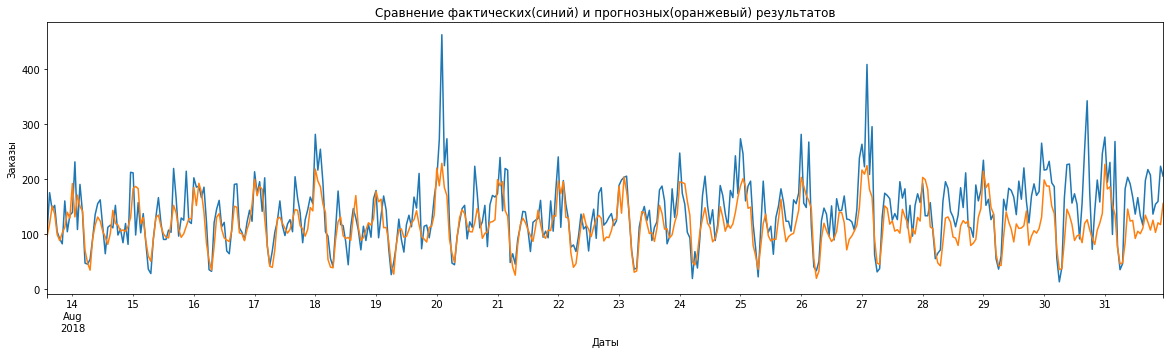

In [28]:
# отобразим на графике реальные целевые значения теста
# и прогнозные значения лучшей модели
predictions = models[4].predict(features_test_scaled)
target_test.plot()
ax = pd.Series(
    predictions, index = target_test.index).plot(
    figsize=(20,5), 
    title='Сравнение фактических(синий) и прогнозных(оранжевый) результатов')

ax.set_xlabel('Даты')
ax.set_ylabel('Заказы')

plt.show() 

### Общий вывод

**Подготовка данных**

- выборка была разделена на составляющие seasonal_decompose()
- на всем периоде наблюдений явно видна сезонность в рамках суток
- наиболее загруженные часы - ночные, наименее загруженные - утренние
- вероятно такое распределение связано с графиком прибытия рейсов
- имеет место четкий тренд на возрастание кол-ва заказов/час
- тренд также может быть связан с характером данных (аэоропорты) - в летние месяцы туристический поток возрастает, что и увеличивает нагрузку на такси. Чтобы оценить корректость этого предположения, нужно иметь данные как минимум за полный год.


**Обучение моделей**

- заранее было подготовлено 3 функции - метрика RMSE, генерация доп. признаков make_feature, show_metrics для единообразного отображения метрик по разным моделям
- исходная выборка была дополнена необходимыми признаками
- исходная выборка была разделена на обучающую и тестовую в пропорции 90/10
- было обучено 5 моделей 
    - LinearRegression
    - Ridge
    - LogisticRegression
    - RandomForestRegressor
    - LGBMRegressor
- на обучающей выборке наилучшие результаты показали модели ансамблей - RandomForestRegressor и LGBMRegressor. 
- Линейные модели показали себя хуже, ориентируясь на метрику RMSE

**Тестирование моделей**

- все обученные модели были проверены на тестовой выборке
- закономерно, что результаты RMSE оказались несколько ниже результатов на обучающей выборке
- **модель LightBGM показала наилучший результат 45.6 , соответствующий требованиям задания быть <= 48.0**